In [1]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from ibllib.atlas import AllenAtlas
from brainbox.core import TimeSeries
from brainbox.processing import bin_spikes

import numpy as np
import pandas as pd

## EDA

In [178]:
pw = 'international'
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password=pw, silent=True)
ba = AllenAtlas()
pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd'

In [179]:
sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)
trials = one.load_object('SWC_043/2020-09-21/001', 'trials', collection='alf')

In [180]:
spikes

{'amps': array([1.12502950e-04, 1.69044700e-04, 7.31735374e-05, ...,
        6.32226820e-05, 8.56651966e-05, 1.58687280e-04]),
 'clusters': array([639, 518, 208, ...,  36, 258,  99], dtype=uint32),
 'depths': array([3540.57568359, 3132.62036133, 1634.10498047, ...,  293.59072876,
        2001.93505859,  865.07281494]),
 'times': array([5.48913109e-03, 8.12244216e-03, 1.18557439e-02, ...,
        4.29594537e+03, 4.29594561e+03, 4.29594777e+03])}

In [181]:
# the channels are the physicals probes of the neuropixels. There are 384 probes, hence 384 channels
channels['x'].shape

(384,)

In [182]:
spikes['clusters'][spikes['clusters']==1].shape

(36216,)

In [183]:
spikes['times'].max()

4295.947773915647

In [184]:
spikes['depths'][spikes['clusters']==40.21386719]

array([], dtype=float64)

In [185]:
clusters.keys()

dict_keys(['channels', 'depths', 'uuids', 'cluster_id', 'amp_max', 'amp_min', 'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt', 'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio', 'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate', 'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um'])

In [186]:
for i in clusters:
    print(i, ": ", clusters[i][:5])

channels :  [0 0 1 3 3]
depths :  [20. 20. 20. 40. 40.]
uuids :  0    eabfbc37-3a64-4eed-b572-0a64db35612a
1    42b7ac0c-e8ae-4a35-99cd-60d270a9cd6f
2    56e57b59-9778-4f6f-9641-77b53a30e98c
3    01392abf-909f-4b05-b004-30db61cbaa99
4    54677eeb-5d38-417d-83b3-7c42eb9ec431
Name: uuids, dtype: object
cluster_id :  [0 1 2 3 4]
amp_max :  [0.00030135 0.00026349 0.00018865 0.0001384  0.00011936]
amp_min :  [1.23242538e-04 7.65254288e-05 7.30344541e-05 5.74085121e-05
 7.59452488e-05]
amp_median :  [2.06488298e-04 1.50695985e-04 8.47766188e-05 7.39944238e-05
 9.26102445e-05]
amp_std_dB :  [1.28520445 2.07737145 1.10484648 1.26433161 1.82074254]
contamination :  [0.         0.00116977 0.05015565 0.         0.        ]
contamination_alt :  [0.         0.00108176 0.04511687 0.         0.        ]
drift :  [3.32306610e+04 2.11527772e+05 9.37797398e+05 1.57938024e+05
 4.85449360e+01]
missed_spikes_est :  [0.00209059 0.04441329 0.5        0.25724096        nan]
noise_cutoff :  [ -0.54073807   1.6

In [187]:
trials.keys()

dict_keys(['goCueTrigger_times', 'stimOff_times', 'probabilityLeft', 'feedbackType', 'response_times', 'choice', 'firstMovement_times', 'contrastLeft', 'contrastRight', 'stimOn_times', 'rewardVolume', 'feedback_times', 'goCue_times', 'intervals'])

(<Figure size 1152x648 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-09-21_1_SWC_043_probe00, da8dfec1-d265-44e8-84ce-6ae9c109b8bd \n17_575_242 spikes, 914 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

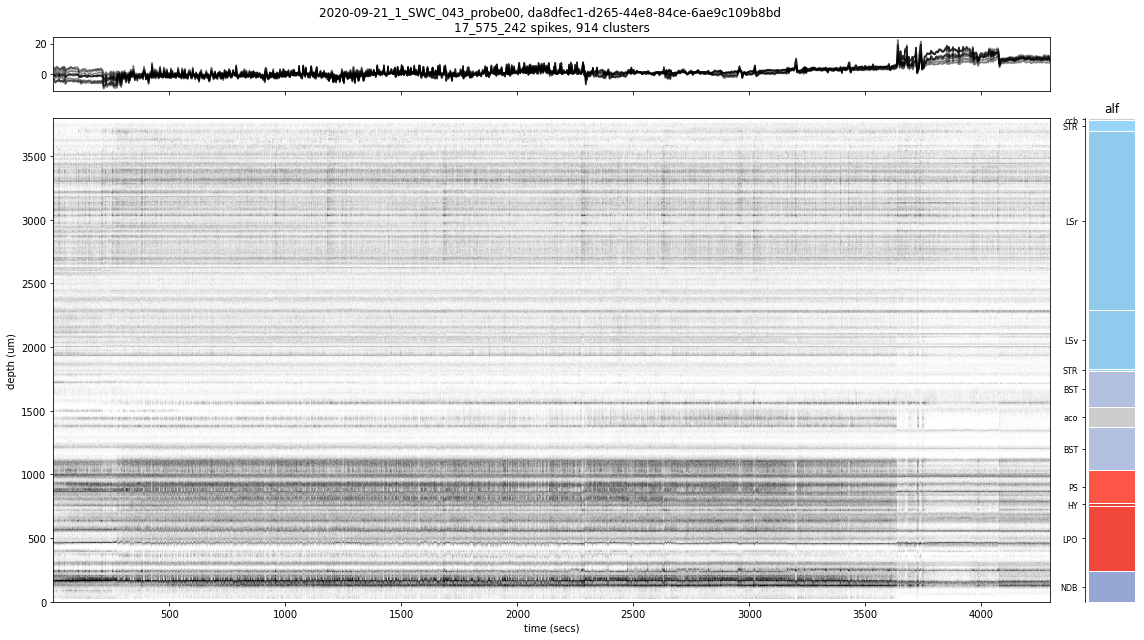

In [188]:
sl.raster(spikes, channels)

### Data Cleaning
1) Filter data for only good clusters (should indicate single neurons)
2) Split data across trials
3) Bin spike times for each neuron, for each trial

In [189]:
good_clusterIDs = clusters['cluster_id'][clusters['label'] == 1] # Find good clusters
good_cluster_loc = np.isin(spikes['clusters'], good_clusterIDs)

In [190]:
good_spikes = {}
for i in spikes:
    good_spikes[i] = spikes[i][good_cluster_loc]

In [191]:
good_spikes

{'amps': array([1.12502950e-04, 1.69044700e-04, 7.31735374e-05, ...,
        2.02525975e-04, 1.10336245e-04, 1.58687280e-04]),
 'clusters': array([639, 518, 208, ...,  99, 114,  99], dtype=uint32),
 'depths': array([3540.57568359, 3132.62036133, 1634.10498047, ...,  894.89599609,
         918.56298828,  865.07281494]),
 'times': array([5.48913109e-03, 8.12244216e-03, 1.18557439e-02, ...,
        4.29593914e+03, 4.29593941e+03, 4.29594777e+03])}

(<Figure size 1152x648 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-09-21_1_SWC_043_probe00, da8dfec1-d265-44e8-84ce-6ae9c109b8bd \n4_139_263 spikes, 165 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

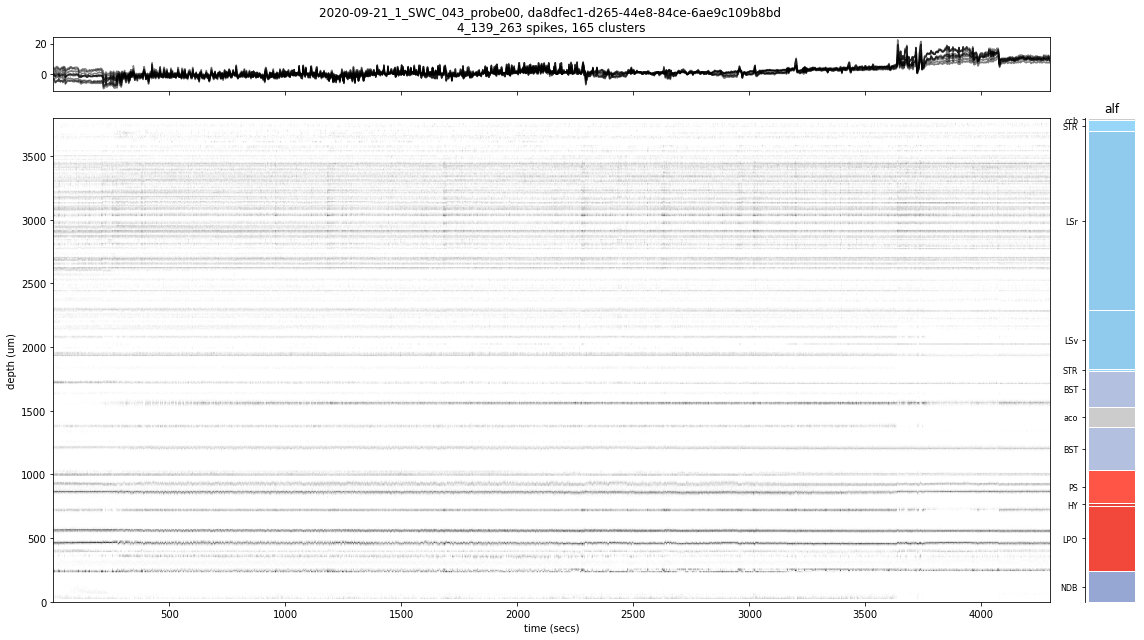

In [192]:
sl.raster(good_spikes, channels)

In [193]:
trials['intervals']

array([[ 266.15101557,  272.30825959],
       [ 272.71315929,  277.05830784],
       [ 277.53001089,  279.87603759],
       ...,
       [2952.64627887, 2957.90602276],
       [2958.71662607, 2966.97139324],
       [2967.84479703, 2985.18913487]])

In [194]:
trials_spikes = [] # The Spike times and results of each trial

for i, interval in enumerate(trials['intervals']):
    time_range = ((good_spikes['times']>interval[0]) & (good_spikes['times']<interval[1])) #Find the spikes corresponding to the current interval
    spike_range = {}
    
    for key in good_spikes:
        spike_range[key] = good_spikes[key][time_range]
        
    spike_range['goCue_times'] = trials['goCue_times'][i]
    spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
    spike_range['choice'] = trials['choice'][i]
    spike_range['feedbackType'] = trials['feedbackType'][i]
    
    
    # Bin Spikes based on time= 0.1 seconds, per cluster
    df = pd.DataFrame(data={'clusters':spike_range['clusters'], 'times':spike_range['times']})
    hist_bins = np.arange(interval[0], interval[1], 0.1)
    df = df.groupby('clusters')['times'].apply(list)
    
    hist_rows = []
    for i in df.iloc:
        hist_rows.append(np.histogram(i, hist_bins)[0])
    spikes_df = pd.DataFrame(hist_rows, columns=hist_bins[:-1], index=df.index) # Clusters are assumed to be good neurons
    spike_range['spikes_df'] = spikes_df
    
    trials_spikes.append(spike_range)

In [200]:
trials_spikes[2]['spikes_df']

,277.530011,277.630011,277.730011,277.830011,277.930011,278.030011,278.130011,278.230011,278.330011,278.430011,...,278.830011,278.930011,279.030011,279.130011,279.230011,279.330011,279.430011,279.530011,279.630011,279.730011
clusters,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
1,1,2,1,4,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,2,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
35,3,2,2,3,1,5,7,11,12,8,...,3,4,5,5,4,2,2,2,6,5
37,1,0,1,1,0,1,1,2,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,2,2,1,2,2,1,1,2,2,1,...,0,0,1,1,0,0,2,0,2,1
830,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,2,2
856,2,0,0,1,3,2,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1


In [198]:
trials_spikes[3]['spikes_df']

,280.244039,280.344039,280.444039,280.544039,280.644039,280.744039,280.844039,280.944039,281.044039,281.144039,...,282.844039,282.944039,283.044039,283.144039,283.244039,283.344039,283.444039,283.544039,283.644039,283.744039
clusters,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,2,0
35,4,2,2,4,2,0,1,5,0,0,...,2,2,4,5,3,4,2,2,1,2
37,0,0,0,0,1,1,0,2,0,1,...,0,0,1,0,0,1,1,0,1,1
38,1,0,1,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,0,0,1,0,0,0,1,0,1,0,...,0,1,1,3,0,1,2,0,0,0
856,2,3,0,0,0,2,2,0,0,0,...,0,0,0,0,0,1,1,2,1,0
861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(<Figure size 1152x648 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-09-21_1_SWC_043_probe00, da8dfec1-d265-44e8-84ce-6ae9c109b8bd \n3_720 spikes, 144 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

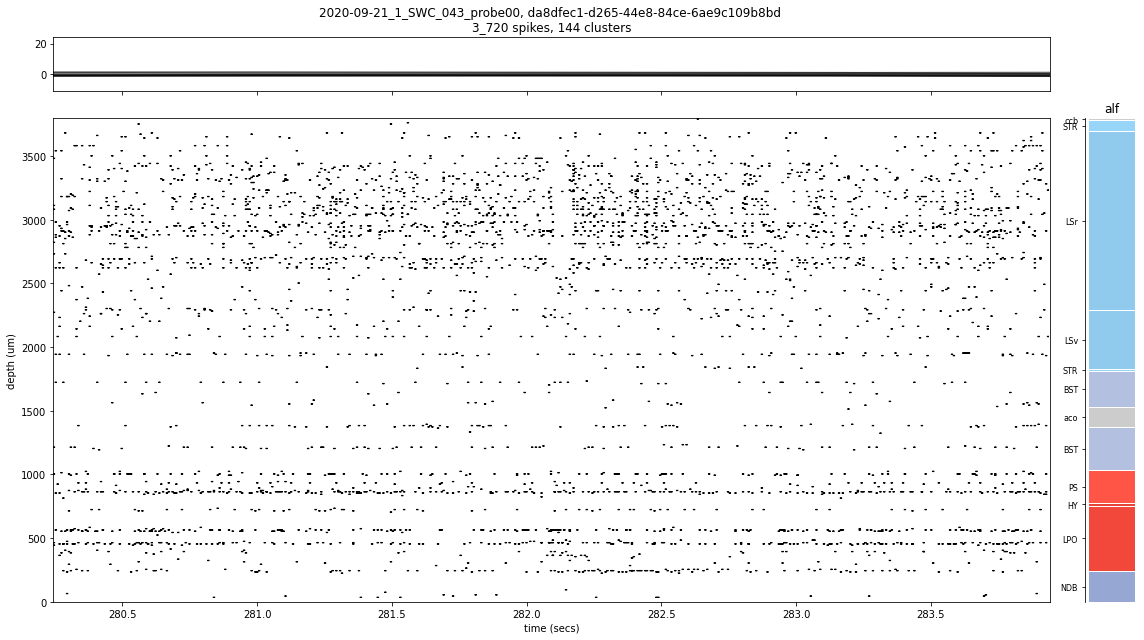

In [196]:
sl.raster(trials_spikes[3], channels)